In [ ]:
import pandas as pd
df_traffic_announcment = pd.read_csv(
"Datasets/traffic-announcment.csv")

sdf_traffic_announcment['ANNOUNCEMENT_STARTING_DATETIME'] = pd.to_datetime(df_traffic_announcment['ANNOUNCEMENT_STARTING_DATETIME'])

# traffic anouncment for 2024
df_2024 = df_traffic_announcment[df_traffic_announcment['ANNOUNCEMENT_STARTING_DATETIME'].dt.year == 2024]
df_2024.to_csv("Datasets/traffic-announcment-2024.csv", index=False)



In [ ]:
print(df_2024['ANNOUNCEMENT_TYPE_DESC'].unique())

# take the accident announcements only
df_2024_accident = df_2024[df_2024['ANNOUNCEMENT_TYPE_DESC'] == 'Kaza Bildirimi']
df_2024_accident.to_csv("Datasets/traffic-announcment-2024-accident.csv", index=False) 

['Kaza Bildirimi' 'Bakım-Onarım Çalışması' 'Çevre Düzenlemesi'
 'Alt Yapı Çalışması' 'İmalat Çalışması' 'Yol Yapım Çalışması']


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Datasets/traffic-announcment-2024-accident.csv", parse_dates=['ANNOUNCEMENT_STARTING_DATETIME'])

df['HOUR'] = df['ANNOUNCEMENT_STARTING_DATETIME'].dt.hour

hourly_counts = df['HOUR'].value_counts().sort_index()

# group the hours
hourly_range = pd.cut(df['HOUR'], bins=range(0, 25), right=False)
range_counts = hourly_range.value_counts().sort_index()


In [ ]:
import pandas as pd
import os

root_path = "Datasets"

months = [
    "january", "february", "march", "april", "may", "june",
    "july", "august", "september", "october", "november", "december"
]

monthly_files = [
    os.path.join(root_path, f"traffic-density-2024-{month}.csv") for month in months
    
]

all_months = []

for file_path in monthly_files:
    df = pd.read_csv(file_path, parse_dates=["DATE_TIME"])

    # control for the year (optional)
    df = df[df["DATE_TIME"].dt.year == 2024]

  
    df["DATE"] = df["DATE_TIME"].dt.date
    df["HOUR"] = df["DATE_TIME"].dt.hour

    # take the average for hours
    agg_df = df.groupby(["DATE", "HOUR"]).agg({
        "MINIMUM_SPEED": "mean",
        "MAXIMUM_SPEED": "mean",
        "AVERAGE_SPEED": "mean",
        "NUMBER_OF_VEHICLES": "mean"
    }).reset_index()

    agg_df.columns = ["DATE", "HOUR", "AVG_MIN_SPEED", "AVG_MAX_SPEED", "AVG_AVG_SPEED", "AVG_VEHICLE_COUNT"]

    all_months.append(agg_df)

final_df = pd.concat(all_months, ignore_index=True)

final_df = final_df.sort_values(by=["DATE", "HOUR"]).reset_index(drop=True)

final_df.to_csv("Datasets/traffic-density-2024-all.csv", index=False)




In [ ]:
import pandas as pd

accidents = pd.read_csv("Datasets/traffic-announcment-2024-accident.csv", parse_dates=["ANNOUNCEMENT_STARTING_DATETIME"])

accidents['DATE'] = accidents['ANNOUNCEMENT_STARTING_DATETIME'].dt.date
accidents['HOUR'] = accidents['ANNOUNCEMENT_STARTING_DATETIME'].dt.hour

hourly_accidents = accidents.groupby(['DATE', 'HOUR']).size().reset_index(name='ACCIDENT_COUNT')

traffic_weather = pd.read_csv("Datasets/traffic-density-2024-all.csv")
traffic_weather['DATE'] = pd.to_datetime(traffic_weather['DATE']).dt.date
traffic_weather['HOUR'] = traffic_weather['HOUR'].astype(int)

# join with the weather dataset
final_df = pd.merge(traffic_weather, hourly_accidents, on=['DATE', 'HOUR'], how='left')

final_df['ACCIDENT_COUNT'] = final_df['ACCIDENT_COUNT'].fillna(0).astype(int)

print(final_df.head())

final_df.to_csv("Datasets/traffic_density_with_weather_and_accidents.csv", index=False)


         DATE  HOUR  AVG_MIN_SPEED  AVG_MAX_SPEED  AVG_AVG_SPEED  \
0  2024-01-01     0      29.183849     101.814003      61.064863   
1  2024-01-01     1      31.073307     100.606727      61.526520   
2  2024-01-01     2      32.170806     100.437037      62.501525   
3  2024-01-01     3      33.020633      97.719395      62.421366   
4  2024-01-01     4      32.140064      99.179172      62.444748   

   AVG_VEHICLE_COUNT  ACCIDENT_COUNT  
0          43.638746               2  
1          38.678741               1  
2          28.713290               3  
3          24.672627               2  
4          24.065939               0  


In [ ]:
import pandas as pd

df = pd.read_csv("Datasets/traffic_density_with_weather_and_accidents.csv")
df['ACCIDENT_CLASS'] = df['ACCIDENT_COUNT'].apply(lambda x:
    0 if x in [0] else
    1
)

# new features after mid report

holiday_dates = [
    "2024-01-01",
    "2024-04-09", "2024-04-10", "2024-04-11", "2024-04-12",
    "2024-04-23",
    "2024-05-01",
    "2024-05-19",
    "2024-06-15", "2024-06-16", "2024-06-17", "2024-06-18", "2024-06-19",
    "2024-07-15",
    "2024-08-30",
    "2024-10-28", "2024-10-29"
]

holiday_dates = set(pd.to_datetime(holiday_dates).date)

df['DATE'] = pd.to_datetime(df['DATE']).dt.date

# is_holiday
df['IS_HOLIDAY'] = df['DATE'].apply(lambda x: 1 if x in holiday_dates else 0)
# weekend or weekday
df["IS_WEEKEND"] = pd.to_datetime(df["DATE"], errors="coerce").dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
# rush hour
df["RUSH_HOUR"] = df["HOUR"].apply(lambda h: 1 if (6 <= h <= 8) or (17 <= h <= 19) else 0)
df.to_csv("Datasets/traffic_density_with_weather_and_accidents.csv", index=False)




In [ ]:
df["RUSH_HOUR"] = df["HOUR"].apply(lambda h: 1 if (6 <= h <= 8) or (17 <= h <= 19) else 0)
df.head(5)

,DATE,HOUR,AVG_MIN_SPEED,AVG_MAX_SPEED,AVG_AVG_SPEED,AVG_VEHICLE_COUNT,ACCIDENT_COUNT,ACCIDENT_CLASS,IS_HOLIDAY,IS_WEEKEND,RUSH_HOUR
0,2024-01-01,0,29.183849,101.814003,61.064863,43.638746,2,1,1,0,0
1,2024-01-01,1,31.073307,100.606727,61.526520,38.678741,1,1,1,0,0
2,2024-01-01,2,32.170806,100.437037,62.501525,28.713290,3,1,1,0,0
3,2024-01-01,3,33.020633,97.719395,62.421366,24.672627,2,1,1,0,0
4,2024-01-01,4,32.140064,99.179172,62.444748,24.065939,0,0,1,0,0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score


features = [
    "HOUR", "AVG_MIN_SPEED", "AVG_MAX_SPEED", "AVG_AVG_SPEED", "AVG_VEHICLE_COUNT","IS_WEEKEND"]
target = "ACCIDENT_CLASS"

X = df[features]
y = df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7795031055900621

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.58      0.65       574
           1       0.79      0.89      0.84      1036

    accuracy                           0.78      1610
   macro avg       0.77      0.74      0.75      1610
weighted avg       0.78      0.78      0.77      1610



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from itertools import chain, combinations

# base features
base_features = ["HOUR", "AVG_MIN_SPEED", "AVG_MAX_SPEED", "AVG_AVG_SPEED", "AVG_VEHICLE_COUNT"]

# extra features
extra_features = ["RUSH_HOUR", "IS_HOLIDAY", "IS_WEEKEND"]

# all combinations
def all_combinations(features):
    return chain.from_iterable(combinations(features, r) for r in range(len(features) + 1))

results = []

for extras in all_combinations(extra_features):
    selected_features = base_features + list(extras)
    X = df[selected_features]
    y = df["ACCIDENT_CLASS"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model = GradientBoostingClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results.append({
        "Features": selected_features,
        "Accuracy": acc,
        "Report": classification_report(y_test, y_pred, output_dict=True)  # istersen string'e çevirebilirim
    })

results_df = pd.DataFrame(results)

for _, row in results_df.iterrows():
    print(f"Features: {row['Features']} | Accuracy: {row['Accuracy']:.4f}")


Features: ['HOUR', 'AVG_MIN_SPEED', 'AVG_MAX_SPEED', 'AVG_AVG_SPEED', 'AVG_VEHICLE_COUNT'] | Accuracy: 0.7776
Features: ['HOUR', 'AVG_MIN_SPEED', 'AVG_MAX_SPEED', 'AVG_AVG_SPEED', 'AVG_VEHICLE_COUNT', 'RUSH_HOUR'] | Accuracy: 0.7783
Features: ['HOUR', 'AVG_MIN_SPEED', 'AVG_MAX_SPEED', 'AVG_AVG_SPEED', 'AVG_VEHICLE_COUNT', 'IS_HOLIDAY'] | Accuracy: 0.7758
Features: ['HOUR', 'AVG_MIN_SPEED', 'AVG_MAX_SPEED', 'AVG_AVG_SPEED', 'AVG_VEHICLE_COUNT', 'IS_WEEKEND'] | Accuracy: 0.7795
Features: ['HOUR', 'AVG_MIN_SPEED', 'AVG_MAX_SPEED', 'AVG_AVG_SPEED', 'AVG_VEHICLE_COUNT', 'RUSH_HOUR', 'IS_HOLIDAY'] | Accuracy: 0.7758
Features: ['HOUR', 'AVG_MIN_SPEED', 'AVG_MAX_SPEED', 'AVG_AVG_SPEED', 'AVG_VEHICLE_COUNT', 'RUSH_HOUR', 'IS_WEEKEND'] | Accuracy: 0.7758
Features: ['HOUR', 'AVG_MIN_SPEED', 'AVG_MAX_SPEED', 'AVG_AVG_SPEED', 'AVG_VEHICLE_COUNT', 'IS_HOLIDAY', 'IS_WEEKEND'] | Accuracy: 0.7776
Features: ['HOUR', 'AVG_MIN_SPEED', 'AVG_MAX_SPEED', 'AVG_AVG_SPEED', 'AVG_VEHICLE_COUNT', 'RUSH_HOUR', 'IS

/tmp/ipython-input-20-3638848389.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette=custom_palette)


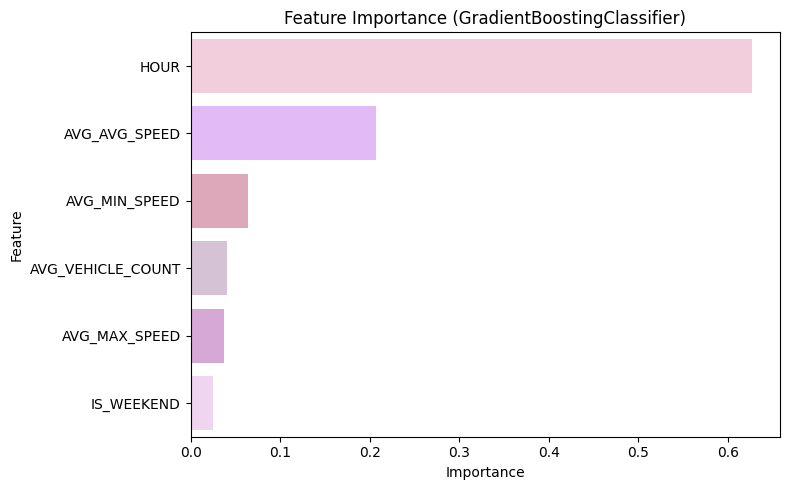

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# feature importance 
importances = model.feature_importances_
feature_names = features

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

custom_palette = ["#F8C8DC", "#E6B0FF", "#E4A0B7", "#D8BFD8", "#DDA0DD", "#F3D1F4"]

plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette=custom_palette)
plt.title("Feature Importance (GradientBoostingClassifier)")
plt.tight_layout()
plt.show()


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


In [ ]:
# 📦 Gerekli kütüphaneler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# IS_WEEKEND is the best
base_features = ["HOUR", "AVG_MIN_SPEED", "AVG_MAX_SPEED", "AVG_AVG_SPEED", "AVG_VEHICLE_COUNT"]
selected_features = base_features + ["IS_WEEKEND"]

X = df[selected_features]
y = df["ACCIDENT_CLASS"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
    "XGBoost": XGBClassifier(random_state=42, n_estimators=500, learning_rate=0.05, max_depth=6),
    "LightGBM": LGBMClassifier(random_state=42, n_estimators=500, learning_rate=0.05, max_depth=6),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42, iterations=500, learning_rate=0.05, depth=6),
    "MLP": MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42),
    "Stacking": StackingClassifier(
        estimators=[
            ('xgb', XGBClassifier(random_state=42)),
            ('lgbm', LGBMClassifier(random_state=42)),
            ('cat', CatBoostClassifier(verbose=0, random_state=42))
        ],
        final_estimator=GradientBoostingClassifier(random_state=42)
    )
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({"Model": name, "Accuracy": acc})

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print("\n📈 Model Karşılaştırmaları:")
print(results_df)


[LightGBM] [Info] Number of positive: 4020, number of negative: 2419
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 6439, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624321 -> initscore=0.507928
[LightGBM] [Info] Start training from score 0.507928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4020, number of negative: 2419
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 6439, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624321 -> initscore=0.507928
[LightGBM] [Info] Start training from score 0.507928
[LightGBM] [Info] Number of positive: 3216, number of negative: 1935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 5151, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624345 -> initscore=0.508031
[LightGBM] [I

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3216, number of negative: 1935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 5151, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624345 -> initscore=0.508031
[LightGBM] [Info] Start training from score 0.508031
[LightGBM] [Info] Number of positive: 3216, number of negative: 1935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 5151, number of used features: 6
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3216, number of negative: 1936
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 5152, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624224 -> initscore=0.507514
[LightGBM] [Info] Start training from score 0.507514


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



📈 Model Karşılaştırmaları:
      Model  Accuracy
2  CatBoost  0.778882
4  Stacking  0.778261
3       MLP  0.767081
1  LightGBM  0.765217
0   XGBoost  0.763975


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


    HOUR  AVG_ACCIDENT_COUNT
0      0            0.824561
1      1            0.482353
2      2            0.275148
3      3            0.210059
4      4            0.157738
5      5            0.176119
6      6            0.465672
7      7            0.982143
8      8            1.768546
9      9            1.752212
10    10            1.722714
11    11            1.731563
12    12            1.740413
13    13            1.790560
14    14            2.008850
15    15            2.378698
16    16            2.355030
17    17            1.732733
18    18            1.773414
19    19            1.577039
20    20            1.407295
21    21            1.516820
22    22            1.371166
23    23            1.116923


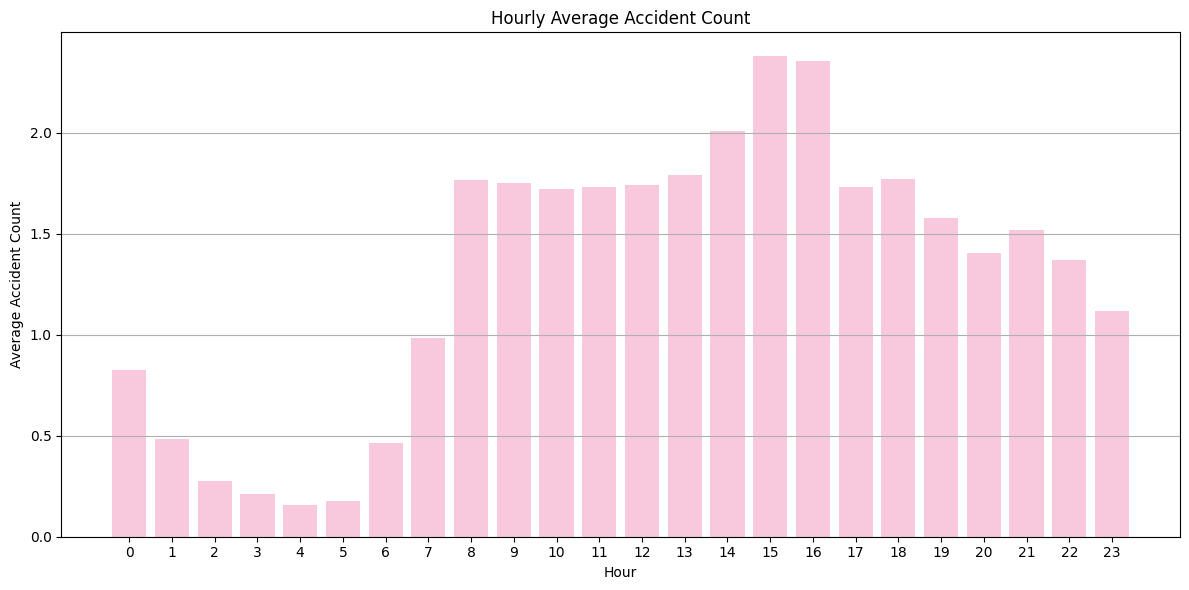

In [ ]:
import matplotlib.pyplot as plt

hourly_accident_count = df.groupby('HOUR')['ACCIDENT_COUNT'].mean().reset_index()
hourly_accident_count.columns = ['HOUR', 'AVG_ACCIDENT_COUNT']

print(hourly_accident_count)

plt.figure(figsize=(12, 6))
plt.bar(hourly_accident_count['HOUR'], hourly_accident_count['AVG_ACCIDENT_COUNT'], color='#F8C8DC')
plt.xticks(range(24))
plt.xlabel("Hour")
plt.ylabel("Average Accident Count")
plt.title("Hourly Average Accident Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


    HOUR  AVG_TRAFFIC_DENSITY
0      0             1.160310
1      1             0.767862
2      2             0.540355
3      3             0.465451
4      4             0.540635
5      5             1.090896
6      6             2.324267
7      7             2.757120
8      8             2.493395
9      9             2.436355
10    10             2.421199
11    11             2.403298
12    12             2.458711
13    13             2.461174
14    14             2.498904
15    15             2.546585
16    16             2.552583
17    17             2.742720
18    18             2.751933
19    19             2.400476
20    20             1.873753
21    21             1.695492
22    22             1.556249
23    23             1.450735


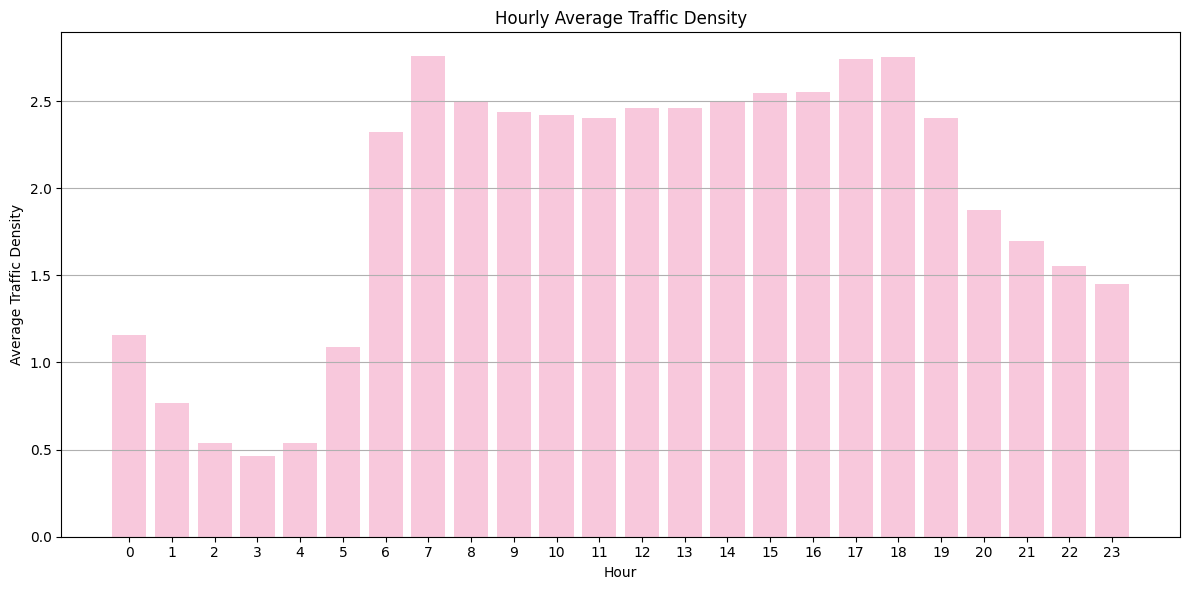

In [ ]:
import matplotlib.pyplot as plt

df['TRAFFIC_DENSITY'] = df['AVG_VEHICLE_COUNT'] / df['AVG_AVG_SPEED']

hourly_traffic_density = df.groupby('HOUR')['TRAFFIC_DENSITY'].mean().reset_index()
hourly_traffic_density.columns = ['HOUR', 'AVG_TRAFFIC_DENSITY']

print(hourly_traffic_density)

plt.figure(figsize=(12, 6))
plt.bar(hourly_traffic_density['HOUR'], hourly_traffic_density['AVG_TRAFFIC_DENSITY'], color='#F8C8DC')
plt.xticks(range(24))
plt.xlabel("Hour")
plt.ylabel("Average Traffic Density")
plt.title("Hourly Average Traffic Density")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
print(df['ACCIDENT_CLASS'].value_counts())


ACCIDENT_CLASS
1    5056
0    2993
Name: count, dtype: int64


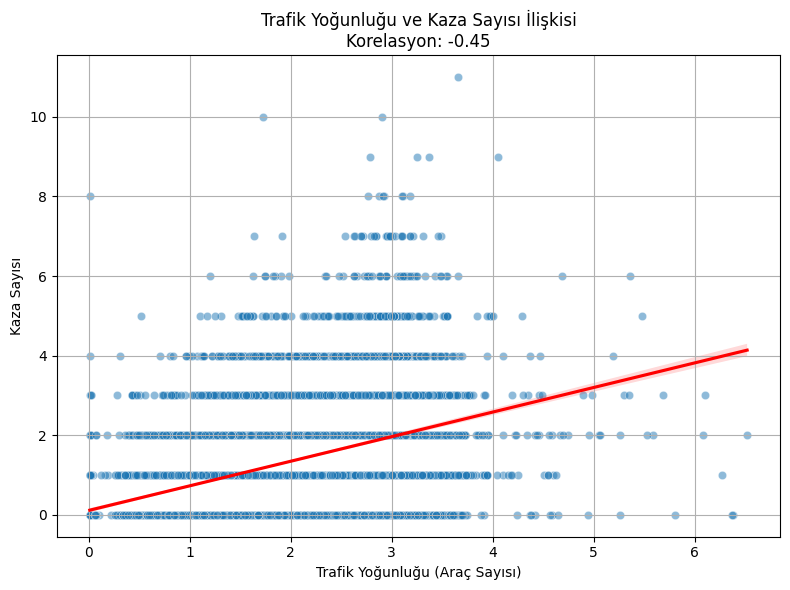

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns




df['TRAFFIC_DENSITY'] = df['AVG_VEHICLE_COUNT'] / df['AVG_AVG_SPEED']

correlation = df[['AVG_AVG_SPEED', 'ACCIDENT_COUNT']].corr().iloc[0, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='TRAFFIC_DENSITY', y='ACCIDENT_COUNT', data=df, alpha=0.5)
sns.regplot(x='TRAFFIC_DENSITY', y='ACCIDENT_COUNT', data=df, scatter=False, color='red')
plt.title(f"Trafik Yoğunluğu ve Kaza Sayısı İlişkisi\nKorelasyon: {correlation:.2f}")
plt.xlabel("Trafik Yoğunluğu (Araç Sayısı)")
plt.ylabel("Kaza Sayısı")
plt.grid(True)
plt.tight_layout()
plt.show()


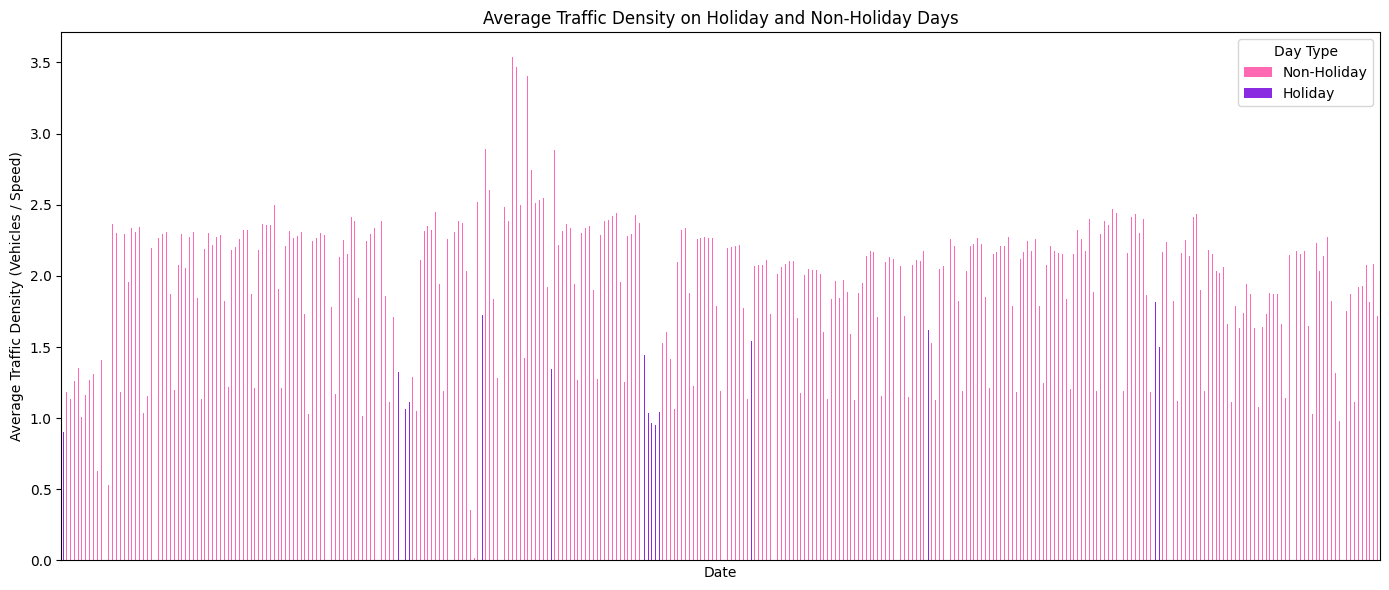

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df["DATE"] = pd.to_datetime(df["DATE"])

df["TRAFFIC_DENSITY"] = df["AVG_VEHICLE_COUNT"] / df["AVG_AVG_SPEED"]

daily_density = df.groupby(["DATE", "IS_HOLIDAY"])["TRAFFIC_DENSITY"].mean().reset_index()
pivot_density = daily_density.pivot(index="DATE", columns="IS_HOLIDAY", values="TRAFFIC_DENSITY")
pivot_density.columns = ["Non-Holiday", "Holiday"]

colors = ["#FF69B4", "#8A2BE2"]  # hot pink, blue violet

pivot_density.plot(kind="bar", figsize=(14, 6), color=colors)
plt.title("Average Traffic Density on Holiday and Non-Holiday Days")
plt.xlabel("Date")
plt.ylabel("Average Traffic Density (Vehicles / Speed)")
plt.legend(title="Day Type")
plt.xticks([], [])  
plt.tight_layout()
plt.show()


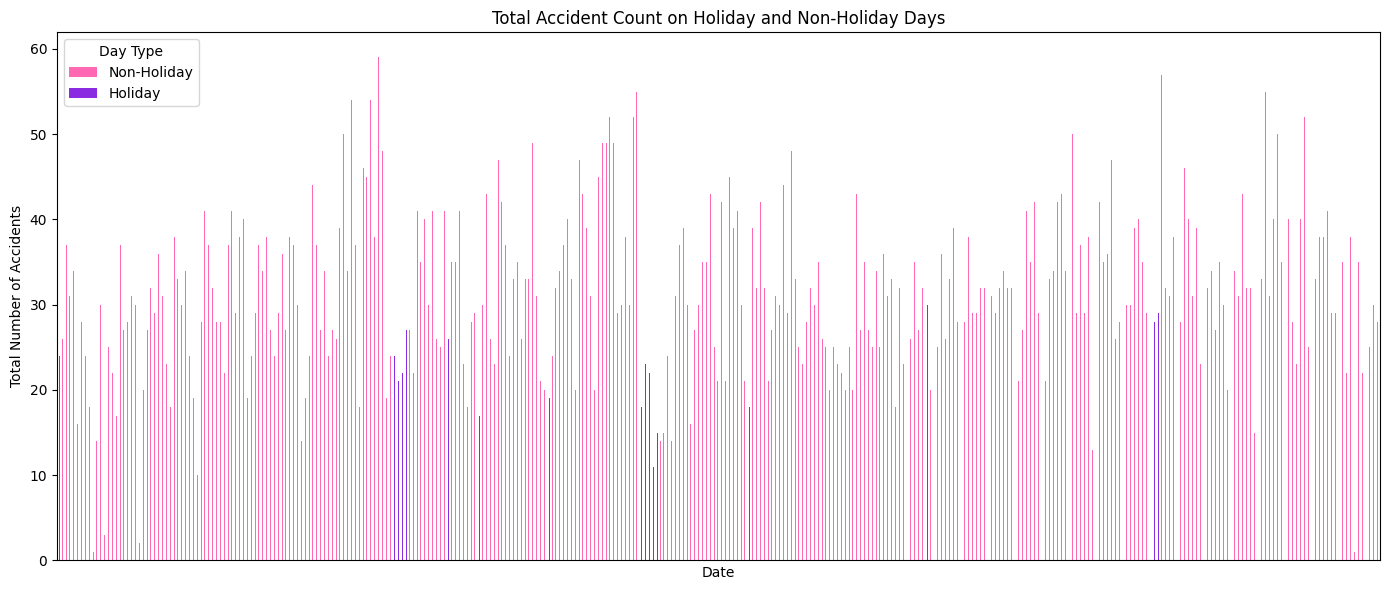

In [ ]:
daily_accidents = df.groupby(["DATE", "IS_HOLIDAY"])["ACCIDENT_COUNT"].sum().reset_index()

pivot_accidents = daily_accidents.pivot(index="DATE", columns="IS_HOLIDAY", values="ACCIDENT_COUNT")
pivot_accidents.columns = ["Non-Holiday", "Holiday"]

pivot_accidents.plot(kind="bar", figsize=(14, 6), color=["#FF69B4", "#8A2BE2"])  # hot pink & blue violet
plt.title("Total Accident Count on Holiday and Non-Holiday Days")
plt.xlabel("Date")
plt.ylabel("Total Number of Accidents")
plt.legend(title="Day Type")
plt.xticks([], [])  # Hide all date labels
plt.tight_layout()
plt.show()


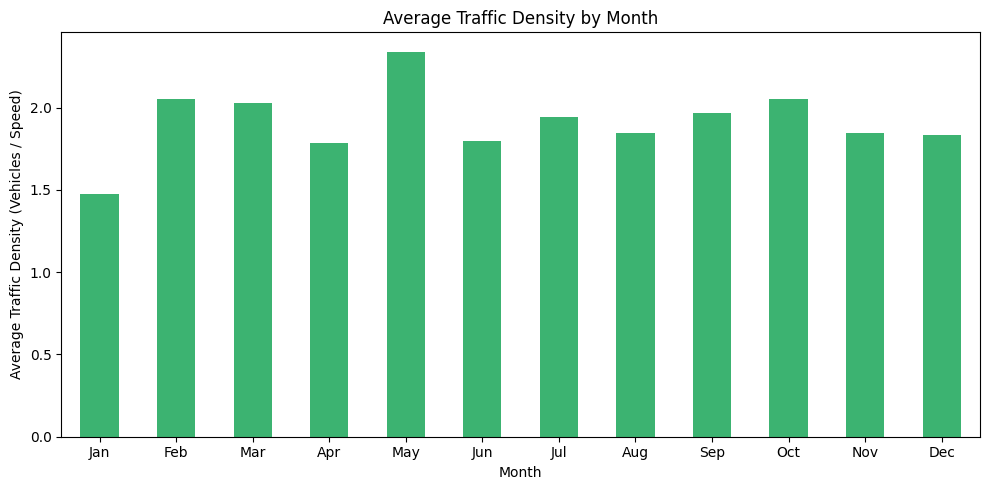

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df["TRAFFIC_DENSITY"] = df["AVG_VEHICLE_COUNT"] / df["AVG_AVG_SPEED"]

df["DATE_parsed"] = pd.to_datetime(df["DATE"], errors="coerce")

df["MONTH"] = df["DATE_parsed"].dt.month

monthly_density = df.groupby("MONTH")["TRAFFIC_DENSITY"].mean()

plt.figure(figsize=(10, 5))
monthly_density.plot(kind="bar", color="mediumseagreen")
plt.title("Average Traffic Density by Month")
plt.xlabel("Month")
plt.ylabel("Average Traffic Density (Vehicles / Speed)")
plt.xticks(ticks=range(0, 12), labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
], rotation=0)
plt.tight_layout()
plt.show()


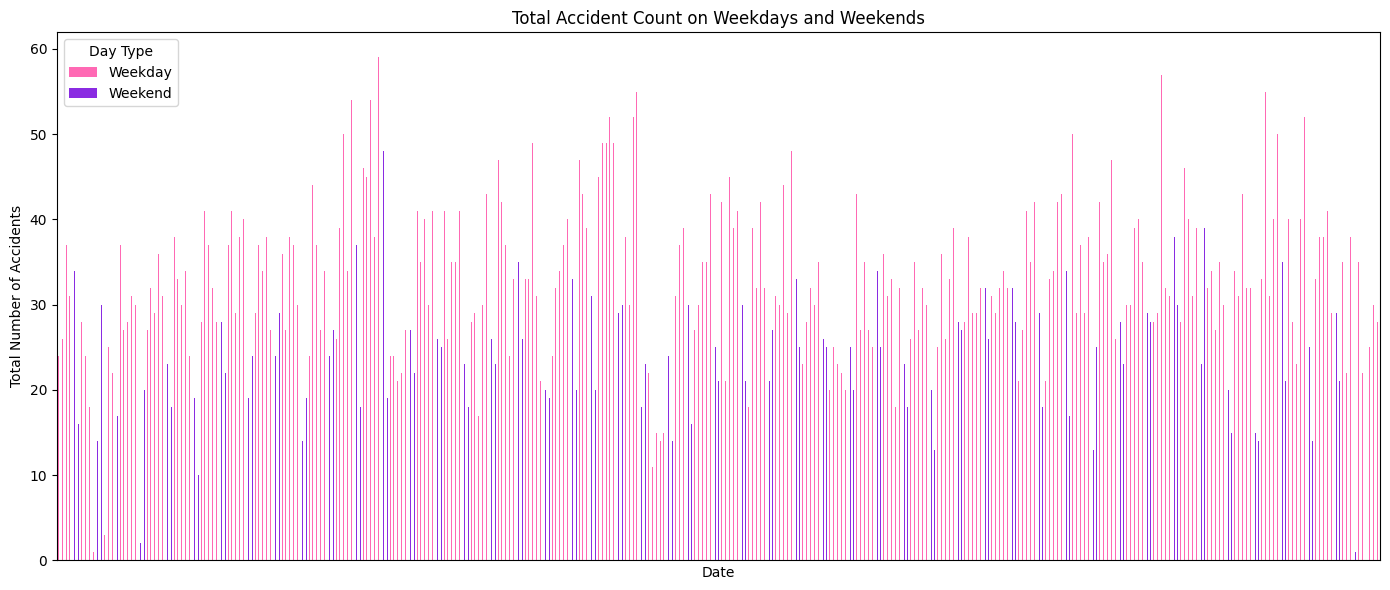

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df["DATE"] = pd.to_datetime(df["DATE"])

df["DAY_OF_WEEK"] = df["DATE"].dt.dayofweek

df["IS_WEEKEND"] = df["DAY_OF_WEEK"].isin([5, 6])

daily_accidents = df.groupby(["DATE", "IS_WEEKEND"])["ACCIDENT_COUNT"].sum().reset_index()
pivot_accidents = daily_accidents.pivot(index="DATE", columns="IS_WEEKEND", values="ACCIDENT_COUNT")
pivot_accidents.columns = ["Weekday", "Weekend"]

pivot_accidents.plot(kind="bar", figsize=(14, 6), color=["#FF69B4", "#8A2BE2"])  # hot pink & blue violet
plt.title("Total Accident Count on Weekdays and Weekends")
plt.xlabel("Date")
plt.ylabel("Total Number of Accidents")
plt.legend(title="Day Type")
plt.xticks([], [])  
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from scipy.stats import ttest_rel

gb = [0.779, 0.781, 0.777, 0.783, 0.779]
cat = [0.776, 0.779, 0.778, 0.781, 0.778]

# t-test
t_stat, p_val = ttest_rel(gb, cat)

print("T-test p-value:", p_val)
if p_val < 0.05:
    print("Significant difference between Gradient Boosting and CatBoost")
else:
    print("No significant difference")


T-test p-value: 0.10793882229227648
No significant difference
